In [1]:
import tensorflow as tf
import numpy as np
#import mnist_handler
import os
import pandas as pd
import matplotlib.pyplot as plt
#os.environ["CUDA_VISIBLE_DEVICES"]="3"; 
INPUT_DIMENSION = 26
NUM_CLASSES = 6

train_dataset = np.array(pd.read_csv("Satimage_dataset/sat_trn.csv",header = None, delimiter=' '))
test_dataset = np.array(pd.read_csv("Satimage_dataset/sat_tst.csv",header = None, delimiter=' '))

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(train_dataset)
print(train_dataset.shape)
print(test_dataset)
print(test_dataset.shape)

[[ 92 115 120 ... 113  87   3]
 [ 84 102 106 ... 104  79   3]
 [ 84 102 102 ... 104  79   3]
 ...
 [ 68  75 108 ... 104  85   4]
 [ 71  87 108 ... 104  85   4]
 [ 71  91 100 ... 100  81   4]]
(4435, 37)
[[ 80 102 102 ... 113  87   3]
 [ 76 102 102 ... 104  83   3]
 [ 80  98 106 ...  96  75   4]
 ...
 [ 56  68  91 ...  92  74   5]
 [ 56  68  87 ...  92  70   5]
 [ 60  71  91 ... 108  92   5]]
(2000, 37)


In [3]:
y_train = train_dataset[:,36] -1
y_test = test_dataset[:,36]-1
x_train = train_dataset[:,0:36]
x_test = test_dataset[:,0:36]
print(y_test.shape)
y_train = np.where(y_train < 6, y_train, 5)
y_test = np.where(y_test < 6, y_test, 5)
print(np.unique(y_train))

(2000,)
[0 1 2 3 4 5]


In [4]:
total = np.concatenate((x_train,x_test),axis = 0)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(total)
total = scaler.transform(total)
total.shape

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(6435, 36)

In [5]:
x_train = total[0:4435]
#y_train = total[0:38,0]
y_train = np.array(y_train, dtype=np.int16)
x_test = total[4435:]
#y_test = total[38:,0]
y_test = np.array(y_test, dtype=np.int16)
print(x_train.shape)
print(x_test.shape)
print(y_train)
print(y_test.shape)

(4435, 36)
(2000, 36)
[2 2 2 ... 3 3 3]
(2000,)


In [6]:
p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]
x_train.shape
y_train

array([2, 2, 1, ..., 4, 0, 5], dtype=int16)

In [107]:
#pCA
import time
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(0.9965)
time_sum = 0
t1 = time.time()
pca.fit(x_train)
t2 = time.time()
time_sum+= t2-t1
train_img = pca.transform(x_train)
test_img  = pca.transform(x_test)
train_img.shape,test_img.shape,x_train.shape

((4435, 26), (2000, 26), (4435, 36))

In [108]:

border = 435
x_train_init = train_img[:border]
y_train_init = y_train[:border]
x_train_seq = train_img[border:]
y_train_seq = y_train[border:]

In [109]:
tf.reset_default_graph() # clear all the tensors
sess = tf.Session()


"""Placeholders"""
X_ = tf.placeholder(tf.float32, [None, INPUT_DIMENSION])
#X_ = tf.reshape(X, [-1, INPUT_DIMENSION]) # Flatten X: [N,D]
Y = tf.placeholder(tf.int64, [None]) # labels
Y_ = tf.one_hot(indices=Y, depth=NUM_CLASSES) # one_hot labels: [N,M]

"""Some constants"""
D = INPUT_DIMENSION
M = NUM_CLASSES # Number of outputs
C = tf.constant(2.0**(2))

"""Weights"""
alpha_1 = tf.get_variable('alpha_1',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 1st subnetwork
alpha_2 = tf.get_variable('alpha_2',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 2st subnetwork
alpha_3 = tf.get_variable('alpha_3',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_1 = tf.get_variable('beta_1',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_2 = tf.get_variable('beta_2',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_3 = tf.get_variable('beta_3',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [110]:
k = tf.get_variable('k',shape=[D, D],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
m = tf.get_variable('m',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [111]:
"""Utility functions"""
def mul(A, B):
    return tf.matmul(A, B)

def inv(A):
    return tf.matrix_inverse(A)

def t(A):
    return tf.transpose(A)

def sin(A):
    return tf.math.sin(A)

def asin(A):
    return tf.math.asin(A)

def sqrt(A):
    return tf.sqrt(A)

def sqr(A):
    return tf.math.pow(A, 2)

def pseudo_inv(A, I, C):
    C_I = I/C
    return mul(t(A), inv(C_I + mul(A, t(A))))

def h(A):
    '''activation function'''
    return sin(A)

def h_(A):
    '''inverse activation function'''
    return asin(A)

def u(A):
    '''normalize the input to (0,1]'''
    return tf.math.sigmoid(A) # sigmoid
    
def u_(A):
    '''the inverse of u'''
    ONE = tf.constant(1.0)
    return -(tf.math.log(ONE/A - ONE)) # the inverse of sigmoid
    
def subnet_output(alpha, beta, A):
    return t(mul(beta, h(mul(t(alpha), t(A))))) 

# Initial Training

In [112]:
"""Initial Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
'''some pre-computations'''
X_init = t(X_) # [D,N]
Y_init = t(Y_) # [M,N]
N_init = D # number of dimensions
I_DxD = tf.eye(N_init, dtype=tf.float32) # [D,D]
I_MxM = tf.eye(M, dtype=tf.float32) # [M,M]
C_I = I_DxD/C
H_I = I_MxM/C

add = C_I + mul(X_init, t(X_init))
k = tf.assign(k,add)
X_inv_init = pseudo_inv(X_init, I_DxD, C) # [N,D]

'''1st subnet'''
alpha_1_init_calculated = t(mul(h_(Y_init), X_inv_init)) # ([M,N]x[N,D])T=[D,M]
alpha_1_init = tf.assign(alpha_1, alpha_1_init_calculated) # [D,M]
H_1_init = h(mul(t(alpha_1_init), X_init)) # [M,N]
H_add = H_I + mul(H_1_init,t(H_1_init))
m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_1_init,I_MxM,C) #[N,M]

beta_1_init_calculated = mul(Y_init, t(H_1_init))/sqr(tf.norm(H_1_init)) # [M,M]
beta_1_init_calculated = mul(Y_init,H_pseudo_init)

beta_1_init = tf.assign(beta_1, beta_1_init_calculated) # [M,M]
H_beta_1_init = mul(beta_1_init, t(mul(t(X_init), alpha_1_init))) # [M,N]
E_1_init = Y_init - H_beta_1_init # [M,N]

'''2nd subnet'''
#alpha_2_init_calculated = t(mul(h_(E_1_init), X_inv_init)) # [D,M]    
alpha_2_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_2_init = tf.assign(alpha_2, alpha_2_init_calculated) # [D,M]
H_2_init = h(mul(t(alpha_2_init), X_init)) # [M,N]
H_2_inv_init = pseudo_inv(H_2_init, I_MxM, C) # [M,N]
H_add = H_I + mul(H_2_init,t(H_2_init))
#m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_2_init,I_MxM,C) #[N,M]

beta_2_init_calculated = mul(E_1_init, t(H_2_init))/sqr(tf.norm(H_2_init)) # [M,M]
beta_2_init_calculated = mul(E_1_init, H_pseudo_init)

beta_2_init = tf.assign(beta_2, beta_2_init_calculated) # [M,M]
H_beta_2_init = mul(beta_2_init, t(mul(t(X_init), alpha_2_init))) # [M,N]
E_2_init = Y_init - (H_beta_1_init+H_beta_2_init) # [M,N]

'''3rd subnetwork'''
alpha_3_init_calculated = t(mul(h_(E_2_init), X_inv_init)) # [D,M]    
alpha_3_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_3_init = tf.assign(alpha_3, alpha_3_init_calculated) # [D,M]
H_3_init = h(mul(t(alpha_3_init), X_init)) # [M,N]
H_3_inv_init = pseudo_inv(H_3_init, I_MxM, C) # [M,N]

beta_3_init_calculated = mul(E_2_init, t(H_3_init))/sqr(tf.norm(H_3_init)) # [M,M]
beta_3_init_calculated = mul(E_2_init, H_3_inv_init)

beta_3_init = tf.assign(beta_3, beta_3_init_calculated) # [M,M]
H_beta_3_init = mul(beta_3_init, t(mul(t(X_init), alpha_3_init))) # [M,N]
E_3_init = Y_init - (H_beta_3_init+H_beta_2_init+ H_beta_1_init) # [M,N]

#init_train_graph = H_beta_1_init
init_train_graph = E_3_init



In [113]:
beta_1_init

<tf.Tensor 'Assign_3:0' shape=(6, 6) dtype=float32_ref>

In [114]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [115]:

'''With one subnetwork'''
logits_init = subnet_output(alpha_1, beta_1, X_) 
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [116]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [117]:
"""Initial training"""
sess.run(E_1_init, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: train_img, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: test_img, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.09386002
Initial train training accuracy:  0.7855693
Initial train testing loss:  0.09608829
Initial train testing accuracy:  0.7675


In [118]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [119]:
"""Initial training"""
sess.run(E_2_init, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: train_img, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: test_img, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.09672286
Initial train training accuracy:  0.78759867
Initial train testing loss:  0.09860514
Initial train testing accuracy:  0.77


In [120]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [122]:
"""Initial training"""
t1 = time.time()
sess.run(init_train_graph, feed_dict={X_: x_train_init, Y: y_train_init})
t2 = time.time()
print("Initial training done")
time_sum+= t2-t1
"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: train_img, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: test_img, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.095587105
Initial train training accuracy:  0.7894025
Initial train testing loss:  0.097521596
Initial train testing accuracy:  0.77


In [123]:
logits_init = subnet_output(alpha_1, beta_1, X_)+ subnet_output(alpha_2, beta_2, X_)

In [124]:
logic = sess.run(logits_init, feed_dict={X_ : [x_test[4]]})
print(np.argmax(logic,axis =1))
print(y_test[4])
#plt.imshow(x_test[4200])

ValueError: Cannot feed value of shape (1, 36) for Tensor 'Placeholder:0', which has shape '(?, 26)'

In [125]:
logic = sess.run(logits_init, feed_dict={X_ : [x_test[40]]})
print(np.argmax(logic,axis =1))
print(y_test[40])
#plt.imshow(x_test[4000])

ValueError: Cannot feed value of shape (1, 36) for Tensor 'Placeholder:0', which has shape '(?, 26)'

# Sequential Training

In [126]:
"""Sequential Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
X_seq = t(X_) # [D,N]
Y_seq = t(Y_) # [M,N]
pseudo = mul(X_seq, X_) #DXD
k = tf.assign(k, tf.add(k,pseudo)) #DXD
k_inv = inv(k)

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_1))
alpha1_seq = tf.assign(alpha_1,tf.add(alpha_1,new)) #DXM
H_1_seq = h(mul(t(alpha1_seq), X_seq)) # [M,N]
m_su = mul(H_1_seq,t(H_1_seq))
m = tf.assign(m,tf.add(m,m_su))
m_inv = inv(m)
#update = tf.matmul(tf.matmul(m_inv,H_1_seq),h_(Y_seq)- tf.matmul())
H_pseudo_init = pseudo_inv(H_1_seq,I_MxM,C) #[N,M]
#UPDATE = tf.matmul(tf.matmul(K_inverse, HT), inverse_acti_y - tf.matmul(H, self.__outputWeight))
beta_1_seq_calculated = mul(Y_seq, H_pseudo_init) # [M,M]
beta_1_seq = tf.assign(beta_1, beta_1_seq_calculated) # [M,M]
H_beta_1_seq = mul(beta_1_seq, t(mul(X_, alpha1_seq))) # [M,N]
E_1_seq = Y_seq - H_beta_1_seq # [M,N]

'''2nd subnetwork'''

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_2))
alpha2_seq = tf.assign(alpha_2,tf.add(alpha_2,new)) #DXM
H_2_seq = h(mul(t(alpha2_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_2_seq,I_MxM,C) #[N,M]
beta_2_seq_calculated = mul(E_1_seq, H_pseudo_init) # [M,M]
beta_2_seq = tf.assign(beta_2, beta_2_seq_calculated) # [M,M]
H_beta_2_seq = mul(beta_2_seq, t(mul(t(X_seq), alpha2_seq))) # [M,N]
E_2_seq = Y_seq - (H_beta_2_seq+ H_beta_1_seq) # [M,N]

'''3rd subnetwork'''
new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_3))
alpha3_seq = tf.assign(alpha_3,tf.add(alpha_3,new)) #DXM
H_3_seq = h(mul(t(alpha3_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_3_seq,I_MxM,C) #[N,M]
beta_3_seq_calculated = mul(E_2_seq, H_pseudo_init) # [M,M]
beta_3_seq = tf.assign(beta_3, beta_3_seq_calculated) # [M,M]
H_beta_3_seq = mul(beta_3_seq, t(mul(t(X_seq), alpha3_seq))) # [M,N]
E_3_seq = Y_seq - (H_beta_3_seq +H_beta_2_seq + H_beta_1_seq )# [M,N]
seq_train_graph = E_3_seq




In [127]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [128]:
"""Sequential training"""
batch_size = 500
#time_sum = 0
epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(10):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    t1 = time.time()
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(seq_train_graph, feed_dict={X_: x_batch, Y: y_batch})
    t2 = time.time()
    time_sum+=(t2-t1)
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: train_img, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: test_img, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""
#tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
#ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
#print("Sequential train training loss: ", tr_loss)
#print("Sequential train training accuracy: ", tr_acc)
#print("Sequential train testing loss: ", ts_loss)
#print("Sequential train testing accuracy: ", ts_acc)
print("time",time_sum/10)

train_loss: 0.102852, train_accuracy: 0.782638
test_loss: 0.108472, test_accuracy: 0.759000
train_loss: 0.102016, train_accuracy: 0.782413
test_loss: 0.107536, test_accuracy: 0.759000
train_loss: 0.102002, train_accuracy: 0.782413
test_loss: 0.107520, test_accuracy: 0.759000
train_loss: 0.102002, train_accuracy: 0.782413
test_loss: 0.107520, test_accuracy: 0.759000
train_loss: 0.102002, train_accuracy: 0.782413
test_loss: 0.107520, test_accuracy: 0.759000
train_loss: 0.102002, train_accuracy: 0.782413
test_loss: 0.107520, test_accuracy: 0.759000
train_loss: 0.102002, train_accuracy: 0.782413
test_loss: 0.107520, test_accuracy: 0.759000
train_loss: 0.102002, train_accuracy: 0.782413
test_loss: 0.107520, test_accuracy: 0.759000
train_loss: 0.102002, train_accuracy: 0.782413
test_loss: 0.107520, test_accuracy: 0.759000
train_loss: 0.102002, train_accuracy: 0.782413
test_loss: 0.107520, test_accuracy: 0.759000
Sequential training done
time 0.029284167289733886


In [85]:
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [86]:
"""Sequential training"""
batch_size = 500

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(17):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_2_seq, feed_dict={X_: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: train_img, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: test_img, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""

train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accuracy: 0.772000
train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accuracy: 0.772000
train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accuracy: 0.772000
train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accuracy: 0.772000
train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accuracy: 0.772000
train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accuracy: 0.772000
train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accuracy: 0.772000
train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accuracy: 0.772000
train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accuracy: 0.772000
train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accuracy: 0.772000
train_loss: 0.091485, train_accuracy: 0.790079
test_loss: 0.094093, test_accurac

'Sequential training evaluation'

In [29]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [30]:
"""Sequential training"""
batch_size = 500

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(40):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_1_seq, feed_dict={X_: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""

train_loss: 0.069115, train_accuracy: 0.753777
test_loss: 0.072667, test_accuracy: 0.736500
train_loss: 0.069131, train_accuracy: 0.753777
test_loss: 0.072685, test_accuracy: 0.736500
train_loss: 0.069131, train_accuracy: 0.753777
test_loss: 0.072686, test_accuracy: 0.736500
train_loss: 0.069131, train_accuracy: 0.753777
test_loss: 0.072686, test_accuracy: 0.736500
train_loss: 0.069131, train_accuracy: 0.753777
test_loss: 0.072686, test_accuracy: 0.736500
train_loss: 0.069131, train_accuracy: 0.753777
test_loss: 0.072686, test_accuracy: 0.736500
train_loss: 0.069131, train_accuracy: 0.753777
test_loss: 0.072686, test_accuracy: 0.736500
train_loss: 0.069131, train_accuracy: 0.753777
test_loss: 0.072686, test_accuracy: 0.736500
train_loss: 0.069131, train_accuracy: 0.753777
test_loss: 0.072686, test_accuracy: 0.736500
train_loss: 0.069131, train_accuracy: 0.753777
test_loss: 0.072686, test_accuracy: 0.736500
train_loss: 0.069131, train_accuracy: 0.753777
test_loss: 0.072686, test_accurac

'Sequential training evaluation'

In [31]:
logits_ = subnet_output(alpha_1, beta_1, X_) 
logits__ = sess.run(logits_, feed_dict={X_: [x_test[40]]})
print(logits__)
print(np.argmax(logits__))
print(y_test[40])
#plt.imshow(x_test[4000])

[[ 0.18922192 -0.10378116  0.21980067  0.10045598  0.10303856  0.44207096]]
5
3


ValueError: cannot reshape array of size 36 into shape (28,28)

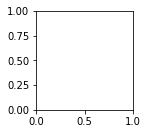

In [32]:
def visualize_alpha(alpha, size):
    tmp = sess.run(alpha)
    plt.figure(figsize=(10,4))
    for i in range(2):
        for j in range(5):
            plt.subplot(2,5,i*5+j+1)
            plt.imshow(np.reshape(tmp[:,i*5+j], [size,size]))

def visualize_beta(beta):
    tmp = sess.run(beta)
    plt.figure(figsize=(4,4))
    plt.imshow(tmp)
    
            
"""visualize subnet nodes"""            
visualize_alpha(alpha_1, 28)
visualize_beta(beta_1)
visualize_alpha(alpha_2, 28)
visualize_beta(beta_2)

In [19]:
n_input_nodes = 36
n_output_nodes = 36
n_hidden_nodes = 26
y_train.shape

(4435,)

In [18]:
for PPAP in range(10):
	tf.reset_default_graph()

	"""BP autoencoder"""
	X = tf.placeholder(tf.float32, [None, n_input_nodes])
	Y = tf.placeholder(tf.float32, [None, n_output_nodes])

	encoding_layer = tf.layers.dense(inputs=X,units=n_hidden_nodes,activation=tf.math.sin)
	Y_hat = tf.layers.dense(inputs=encoding_layer,units=n_output_nodes,activation=None)

	loss = tf.losses.mean_squared_error(labels=Y,predictions=Y_hat)

	optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

	sess = tf.Session()
	sess.run(tf.global_variables_initializer())

	t1 = time.time()
	BATCH_SIZE = 128
	for epoch in range(100):
		i = 0
		while i < len(x_train):
			try:
				batch_x = x_train[i:i+BATCH_SIZE]
				batch_y = x_train[i:i+BATCH_SIZE]
			except:
				batch_x = x_train[i:]
				batch_y = x_train[i:]
			i+=BATCH_SIZE
			sess.run(optimizer, feed_dict={X:batch_x, Y:batch_y})
	t2 = time.time()
	time_sum+=(t2-t1)

KeyboardInterrupt: 

In [20]:
import time
accuracy_sum = 0
time_sum = 0
for PPAP in range(10):
	tf.reset_default_graph()

	"""BP autoencoder"""
	X = tf.placeholder(tf.float32, [None, n_input_nodes])
	Y = tf.placeholder(tf.float32, [None, n_output_nodes])

	encoding_layer = tf.layers.dense(inputs=X,units=n_hidden_nodes,activation=tf.math.sin)
	Y_hat = tf.layers.dense(inputs=encoding_layer,units=n_output_nodes,activation=None)

	loss = tf.losses.mean_squared_error(labels=Y,predictions=Y_hat)

	optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

	sess = tf.Session()
	sess.run(tf.global_variables_initializer())

	t1 = time.time()
	BATCH_SIZE = 128
	for epoch in range(100):
		i = 0
		while i < len(x_train):
			try:
				batch_x = x_train[i:i+BATCH_SIZE]
				batch_y = x_train[i:i+BATCH_SIZE]
			except:
				batch_x = x_train[i:]
				batch_y = x_train[i:]
			i+=BATCH_SIZE
			sess.run(optimizer, feed_dict={X:batch_x, Y:batch_y})
	t2 = time.time()
	time_sum+=(t2-t1)

	"""classification"""
	x_train_encoded = sess.run(encoding_layer, feed_dict={X: x_train})
	x_test_encoded = sess.run(encoding_layer, feed_dict={X: x_test})

	X = tf.placeholder(tf.float32, [None, n_hidden_nodes])
	Y = tf.placeholder(tf.int64, [None])
	Y_ = tf.one_hot(indices=Y, depth=6) # one_hot labels: [N,M]

	fc1 = tf.layers.dense(inputs=X,units=512,activation=tf.nn.relu)
	fc2 = tf.layers.dense(inputs=fc1,units=512,activation=tf.nn.relu)
	out = tf.layers.dense(inputs=fc2,units=6,activation=None)

	loss = tf.losses.softmax_cross_entropy(logits=out,onehot_labels=Y_)
	accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out,axis=1),tf.argmax(Y_,axis=1)),dtype=tf.float32))

	optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

	sess = tf.Session()
	sess.run(tf.global_variables_initializer())

	BATCH_SIZE = 128
	for epoch in range(100):
		i = 0
		while i < len(x_train_encoded):
			try:
				batch_x = x_train_encoded[i:i+BATCH_SIZE]
				batch_y = y_train[i:i+BATCH_SIZE]
			except:
				batch_x = x_train_encoded[i:]
				batch_y = y_train[i:]
			i+=BATCH_SIZE
			sess.run(optimizer, feed_dict={X:batch_x, Y:batch_y})

	"""evaluation"""
	avg_testing_acc = sess.run(accuracy, feed_dict={X: x_test_encoded, Y: y_test})
	print("Testing accuracy: ",avg_testing_acc)
	accuracy_sum+=avg_testing_acc

print("==========================================")
print("BP	 ===================================")
print("==========================================")
print("Average time: ", time_sum/10.0)
print("Average accuracy: ", accuracy_sum/10.0)
print("==========================================")

Testing accuracy:  0.8975
Testing accuracy:  0.906
Testing accuracy:  0.905
Testing accuracy:  0.9005
Testing accuracy:  0.893
Testing accuracy:  0.899
Testing accuracy:  0.9055
Testing accuracy:  0.904
Testing accuracy:  0.913
Testing accuracy:  0.9
BP	 ===================================
Average time:  3.3636444807052612
Average accuracy:  0.9023499906063079


In [ ]:
sess.run(tf.math.sin(tf.constant([0.9])))